username : 'acq22jj'
Made on Windows 11 19 12th gel Laptop

# [COM6513] Assignment: Topic Classification with a Feedforward Network


### Instructor: Nikos Aletras


The goal of this assignment is to develop a Feedforward neural network for topic classification. 



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**1 mark**)


- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**1 mark**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**1 mark**)
    - **Output layer** with a **softmax** activation. (**1 mark**)


- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**1 mark**)
    - Perform a **Forward pass** to compute intermediate outputs (**2 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**3 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**1 marks**)



- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500} and the dropout rate {e.g. 0.2, 0.5}. Please use tables or graphs to show training and validation performance for each hyperparameter combination  (**2 marks**). 



- After training a model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy. Does your model overfit, underfit or is about right? (**1 mark**).



- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**1 marks**).



- Extend you Feedforward network by adding more hidden layers (e.g. one more or two). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**3 marks**)


- Provide well documented and commented code describing all of your choices. In general, you are free to make decisions about text processing (e.g. punctuation, numbers, vocabulary size) and hyperparameter values. We expect to see justifications and discussion for all of your choices. You must provide detailed explanations of your implementation, provide a detailed analysis of the results (e.g. why a model performs better than other models etc.) including error analyses (e.g. examples and discussion/analysis of missclasifications etc.)  (**10 marks**). 



- Provide efficient solutions by using Numpy arrays when possible. Executing the whole notebook with your code should not take more than 10 minutes on any standard computer (e.g. Intel Core i5 CPU, 8 or 16GB RAM) excluding hyperparameter tuning runs and loading the pretrained vectors. You can find tips in Lab 1 (**2 marks**). 



### Data 

The data you will use for the task is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

Class 1: Politics, Class 2: Sports, Class 3: Economy

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You **must** submit a Jupyter Notebook file (assignment_yourusername.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`, you need to have a Latex distribution installed e.g. MikTex or MacTex and pandoc). If you are unable to export the pdf via Latex, you can print the notebook web page to a pdf file from your browser (e.g. on Firefox: File->Print->Save to PDF).


You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/3/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are **not allowed to use any third-party library** such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras, Pytorch etc.. You should mention if you've used Windows to write and test your code because we mostly use Unix based machines for marking (e.g. Ubuntu, MacOS). 

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results and discussion is as important as the implementation and accuracy of your models. Please be brief and consice in your discussion and analyses. 

This assignment will be marked out of 30. It is worth 30\% of your final grade in the module.

The deadline for this assignment is **23:59 on Mon, 26 Apr 2023** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade.



In [ ]:
%pip install wordcloud

In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc
from wordcloud import WordCloud
# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [3]:
train_df = pd.read_csv('data_topic/train.csv',header=None)
test_df = pd.read_csv('data_topic/test.csv',header=None)
dev_df = pd.read_csv('data_topic/dev.csv',header=None)

train_df.rename(columns={0:'label',1:'text'},inplace=True)
dev_df.rename(columns={0:'label',1:'text'},inplace=True)
test_df.rename(columns={0:'label',1:'text'},inplace=True)

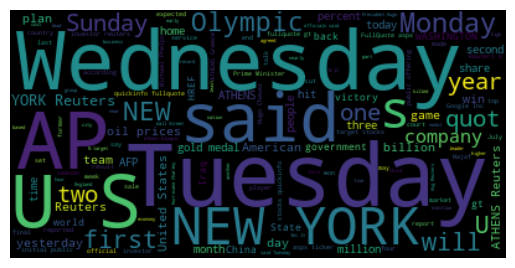

In [4]:
# Join all text samples into a single string
train_text = " ".join(train_df['text'].values.tolist())

# Generate a word cloud
wordcloud = WordCloud().generate(train_text)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

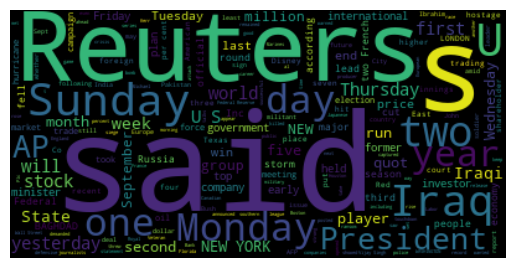

In [5]:
# Join all text samples into a single string
dev_text = " ".join(dev_df['text'].values.tolist())

# Generate a word cloud
wordcloud = WordCloud().generate(dev_text)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

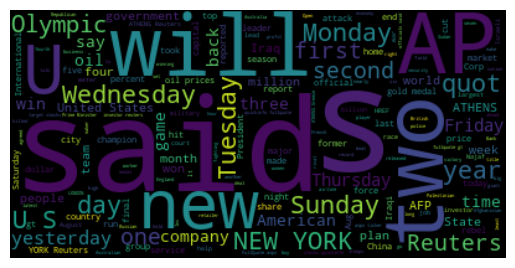

In [6]:
# Join all text samples into a single string
test_text = " ".join(test_df['text'].values.tolist())

# Generate a word cloud
wordcloud = WordCloud().generate(test_text)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [7]:
dev_df.isnull().values.any()

False

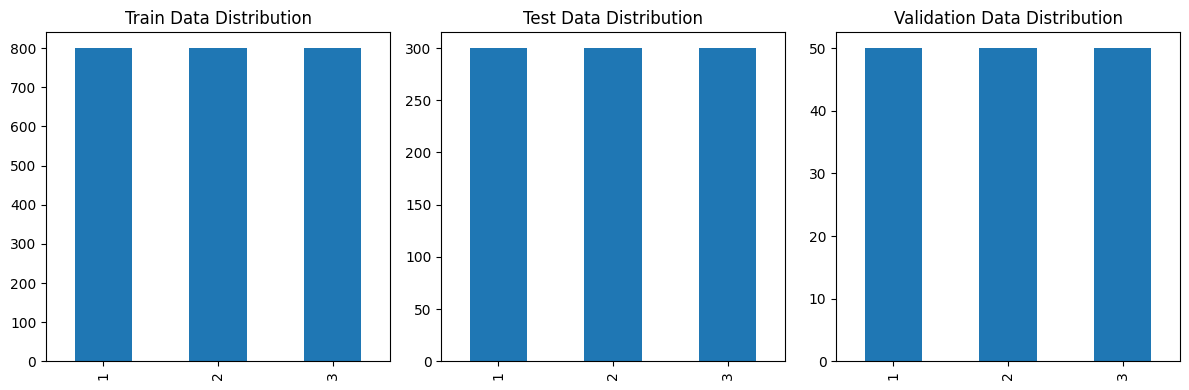

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

train_df['label'].value_counts().plot(ax=axs[0], kind='bar', title='Train Data Distribution')
test_df['label'].value_counts().plot(ax=axs[1], kind='bar', title='Test Data Distribution')
dev_df['label'].value_counts().plot(ax=axs[2], kind='bar', title='Validation Data Distribution')

plt.tight_layout()
plt.show()


The Datasets are balanced and we do not require more manipulations to achieve balance.

# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [9]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']


### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [10]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
                   stop_words=[], vocab=set()):
    """Summary : Extracts n-grams from a text string.

    Args:
        x_raw (str): text string
        ngram_range (tuple, optional): (1,1)> Unigrams, (1,2)> unigrams and bigrams, (1,3) >> unigrams,bigrams and trigrams.
        token_pattern (regexp, optional): token pattern used to extract words alphabetical words containing at least two
        characters (i.e., a word boundary followed by one or more alphabetical characters, followed by
        another word boundary). 
        stop_words (list, optional):A list of stop words to remove from the input text. Defaults to an empty list. Defaults to [].
        vocab (_type_, optional): A set of n-grams to restrict the output to. If empty, all n-grams within the specified range
        will be returned. Defaults to an empty set.. Defaults to set().

    Returns:
        List:  of n-grams extracted from the input text, optionally restricted to a given vocabulary
    """
    # Remove periods from the text, can cause problems when using GloVe Embeddings {cannot convert '.' to float}
    x_raw_punc =re.sub(r"\.", "", x_raw)
    
    
    # Convert all words to lowercase and remove stopwords
    x = [w.lower() for w in x_raw_punc.split() if w.lower() not in stop_words]
    
    # Extract ngrams
    ngrams = []
    for n in range(ngram_range[0], ngram_range[1]+1):
        for i in range(len(x)-n+1):
            ngrams.append(' '.join(x[i:i+n]))
    
    # If vocabulary  provided
    if vocab:
        ngrams = [ng for ng in ngrams if ng in vocab]
    
    return ngrams






### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [11]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
              min_df=0, keep_topN=0, 
              stop_words=[],vocab=set()):
    """Summary: Extracts a vocabulary of n-grams from a list of documents.

    Args:
        X_raw (list): A list of strings representing the input documents.
        ngram_range (tuple, optional): The range of n-gram sizes to extract (inclusive).
            Defaults to (1,3).
        token_pattern (str, optional):passed to extract_ngrams. Defaults to r'\b[A-Za-z][A-Za-z]+\b'.
        min_df (int, optional): The minimum number of documents in which an n-gram must appear to
            be included in the vocabulary.
        keep_topN (int, optional): The maximum number of most frequent n-grams to keep in the
            vocabulary. If set to 0 (the default), all n-grams are included in the vocabulary.
        stop_words (list, optional): passed to extract_ngrams. Defaults to [].
        vocab (set, optional): A set of n-grams to include in the vocabulary, in addition to those
            extracted from the input text, passed to extract_ngrams. Defaults to set().

    Returns:
        
            - vocab (set): The set of n-grams in the vocabulary.
            - df (dict): A dictionary containing the document frequency (df) of each n-gram in the
              vocabulary (i.e., the number of documents in which the n-gram appears).
            - ngram_counts (dict): A dictionary containing the frequency count of each n-gram in
              the input text.
    """
    
    # Initialize dictionaries for counting ngrams
    ngram_counts = Counter() # From Collections module
    doc_freq = Counter()
    
    # Loop through each document and count ngrams
    for doc in X_raw:
        # Extract ngrams from the document
        ngrams = extract_ngrams(doc, ngram_range=ngram_range, 
                                token_pattern=token_pattern, stop_words=stop_words, vocab=vocab)
        
        # Count ngrams in the document
        doc_counts = Counter(ngrams)
        doc_freq.update(set(ngrams))
        
        # Update overall counts
        ngram_counts.update(doc_counts)
    
    # Calculate document frequency
    df = {k:doc_freq[k] for k in doc_freq if doc_freq[k] >= min_df}
    
    # Sort ngrams by frequency and keep top N
    if keep_topN > 0:
        ngram_counts = dict(ngram_counts.most_common(keep_topN))
        vocab = set(ngram_counts.keys())
    
    else:
        vocab = set(ngram_counts.keys())
    
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

Selecting top 5000 words to form the vocabulary for training our neural network, It strikes the balance between computation efficiency and accuracy, which was revealed after running iterations of 9212 words, 12000, 7000 and 3000 as vocab size.

In [12]:
vocab,df,ngram_counts = get_vocab(train_df['text'].values, ngram_range=(1,1),stop_words=stop_words,min_df=0,keep_topN=5000)

In [13]:
vocab_dev,df_Dev,ngram_counts_dev = get_vocab(dev_df['text'].values, ngram_range=(1,1),stop_words=stop_words,min_df=0,keep_topN=5000)

In [14]:
vocab_test,df_test,ngram_counts_test = get_vocab(test_df['text'].values, ngram_range=(1,1),stop_words=stop_words,min_df=0,keep_topN=5000)

Getting top 5000 words from all three datasets, min_df = 0, because by selectingn top 5000, it automatically filters out the least occuring ones.

In [15]:
sorted_word_freq = dict(sorted(ngram_counts.items(), key=lambda x: x[1], reverse=True))

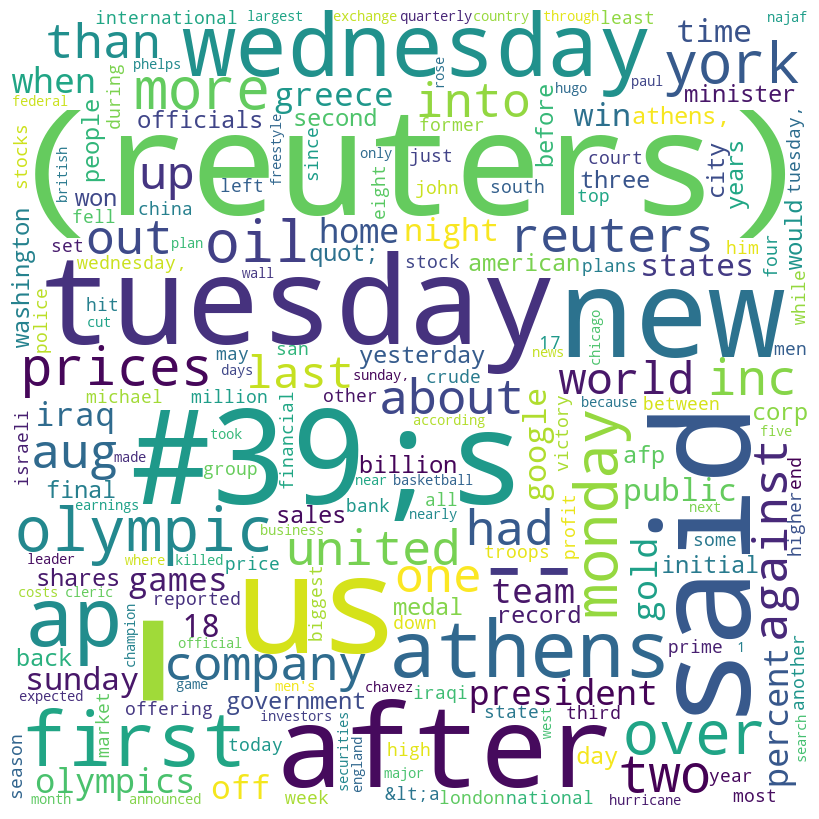

In [16]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(sorted_word_freq)

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

Most Frequent Ngrams in the training dataset, ';' is one of the most frequent, can be removed by uncommenting the line in extract_ngrams above period remover, but it leaves other words like Jamie's to two words. We can observe there are frequently occuring numbers as well which were not pruned when we extracted the ngrams.

Then, you need to create vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [17]:
len(vocab)

5000

In [18]:
vocab_id = {ngram: i for i, ngram in enumerate(sorted(vocab))} # Vocabulary to id's
id_vocab = {i: ngram for ngram, i in vocab_id.items()} # Id's to vocabulary

Vocab from training set is used, not from dev and test sets, {explained later on}

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [19]:
def represent_text_as_vocab_list(df, vocab):
    """
    Given a DataFrame `df` and a vocabulary `vocab`, extract ngrams from the text column in `df` 
    using the words in `vocab` from extract ngrams function defined above, and return a new DataFrame with the updated text column. 

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the text column to be processed.
    vocab : list
        A list of words to use as the vocabulary when extracting ngrams from the text.

    Returns
    -------
    pandas.DataFrame
        A new DataFrame with the same columns as `df`, but with the text column updated to a list 
        of ngrams extracted from the original text using the words in `vocab`.
    """
    dfout = df.copy()
    dfout['text'] = dfout['text'].apply(lambda text: extract_ngrams(text, vocab=vocab))
    return dfout

Converting Dataset 'Text' Columns to list of words from the selected vocab

In [20]:
train_to_vocab = represent_text_as_vocab_list(train_df, vocab)
test_to_vocab = represent_text_as_vocab_list(test_df, vocab)
dev_to_vocab = represent_text_as_vocab_list(dev_df, vocab)

Then convert them into lists of indices in the vocabulary:

In [21]:
def text_to_index(df_col, vocab):
    dfout = df_col.copy()
    df_col_indices = dfout.apply(lambda text: [vocab_id[word] for word in text if word in vocab_id])
    return df_col_indices

In [22]:
train_to_index = text_to_index(train_to_vocab['text'], vocab_id)
test_to_index = text_to_index(test_to_vocab['text'], vocab_id)
dev_to_index = text_to_index(dev_to_vocab['text'], vocab_id)

Here vocab_id of training set is passed as argument for solving the problem of unknown words which may be exclusive to the training set. Adding Words from test and dev set may be pointless as their embeddings will not get updated when training.

We want to convert these to numpy arrays, as it is easier to handle a consistent use of data types throughout the program, making the code cleaner and easier to debug in case of errors.

In [23]:
X_tr = train_to_index.to_numpy()
X_test = test_to_index.to_numpy()
X_dev = dev_to_index.to_numpy()

Now we need to reshape every training instance which makes it easier to process them later on.

In [24]:
for i in range(len(X_tr)):
    X_tr[i] = np.array(X_tr[i]).reshape(-1,1)
for i in range(len(X_test)):
    X_test[i] = np.array(X_test[i]).reshape(-1,1)
for i in range(len(X_dev)):
    X_dev[i] = np.array(X_dev[i]).reshape(-1,1)

Put the labels `Y` for train, dev and test sets into arrays: 

Creating a label >> One-Hot Encoding Dictionary to convert our labels to one hot vectors in numpy

In [25]:
label_map = {1: [1, 0, 0], 2: [0, 1, 0], 3: [0, 0, 1]}

In [26]:
Y_tr = train_df['label'].map(label_map).to_numpy()
Y_test = test_df['label'].map(label_map).to_numpy()
Y_dev = dev_df['label'].map(label_map).to_numpy()

Again Reshaping to make processing easier on later in backward pass and SGD

In [27]:
for i in range(len(Y_tr)):
    Y_tr[i] = np.array(Y_tr[i]).reshape(-1,1)
for i in range(len(Y_test)):
    Y_test[i] = np.array(Y_test[i]).reshape(-1,1)
for i in range(len(Y_dev)):
    Y_dev[i] = np.array(Y_dev[i]).reshape(-1,1)

In [28]:
type(Y_test[0])

numpy.ndarray

Now We will find the longest length of input that any dataset has, which will help in deciding the minimum dimensions of a filter we will use to extract from embedding matrix and feed to our neural network as input

In [29]:
max_len = 0

for i in range(len(X_tr)):
    if len(X_tr[i]) > max_len:
        max_len = len(X_tr[i])
   
        
for i in range(len(X_test)):
    if len(X_test[i]) > max_len:
        max_len = len(X_test[i])
    

for i in range(len(X_dev)):
    if len(X_dev[i]) > max_len:
        max_len = len(X_dev[i])
  

        
        

In [30]:
max_len

77

We can pass >77 values as our embedding size to our network weights function to initalize weights for our neural network.

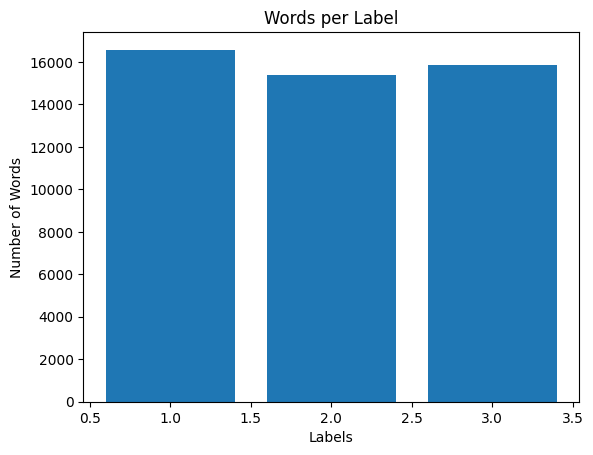

In [282]:
words_per_label = {label: 0 for label in train_to_vocab['label'].unique()}
words_per_label
for i, row in train_to_vocab.iterrows():
    label = row['label']
    words = row['text']
    count = sum([1 for word in words if word in vocab])
    words_per_label[label] += count
plt.bar(words_per_label.keys(), words_per_label.values())
plt.title("Words per Label")
plt.xlabel("Labels")
plt.ylabel("Number of Words")


plt.show()

As we can see our vocab is nearly balanced in represnting the labels.

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer 
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

Kaiming Initialisation is an improvement over He initialisation and allows better and faster training of neural network, We can use it to update our network weights function , but I have left it commented out for submission.

In [31]:
def kaiming_init(n_in, n_out):
    """Kaiming initialization for weights of a layer with ReLU activation function.
    
    Args:
        n_in (int): number of input neurons.
        n_out (int): number of output neurons.
    
    Returns:
        ndarray: weights of shape (n_in, n_out) initialized using Kaiming initialization.
    """
    """ W1 = kaiming_init(n_input, n_hidden)
        W2 = kaiming_init(n_hidden, n_output)"""
    std = np.sqrt(2.0 / n_in)
    weights = np.random.normal(0, std, size=(n_in, n_out)).astype(np.float32)
    return weights

In [32]:
def network_weights(vocab_size=1000,embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val=0.5, make_embedding=True, hidden=False,kaiming_init=False):
    
    """
    Initializes the weights of a neural network with a given architecture.

    Args:
        vocab_size (int): The size of the vocabulary for the embedding layer. Defaults to 1000.
        embedding_dim (int): The dimensionality of the embedding layer. Defaults to 300.
        hidden_dim (list): A list of integers representing the number of hidden units in each
            hidden layer. Defaults to an empty list.
        num_classes (int): The number of classes in the output layer. Defaults to 3.
        init_val (float): The initial value to use for weight initialization. Defaults to 0.5.
        make_embedding (bool): Whether to include an embedding layer. Defaults to True.
        kaiming (bool): Whether to use Kaiming initialization for the hidden layers. If False,
            uses uniform initialization. Defaults to False.

    Returns:
        dict: A dictionary containing the initialized weight matrices for each layer. The keys
            are 'emb' for the embedding layer, 'hidden' for the hidden layers, and 'o' for the
            output layer.
    """
    
    
    
    W = {}
    h =[]
    
    if make_embedding:
        # Embedding layer weights
        W_emb = np.random.uniform(-init_val, init_val, size=(vocab_size, embedding_dim)).astype(np.float32)
        W['emb'] =W_emb
    last_dim = embedding_dim
    if hidden:
        
        # Hidden layers weights
        
        for i, dim in enumerate(hidden_dim):
            W_hid = np.random.uniform(-init_val, init_val, size=(dim,last_dim)).astype(np.float32)
            h.append(W_hid)
            last_dim = dim
        W['hidden'] = h
    
    # Output layer weights
    W_out = np.random.uniform(-init_val, init_val, size=(num_classes, last_dim)).astype(np.float32)
    
    W['o'] =  W_out
    
    return W

np.float32 is used throughout the notebook

In [33]:
W_test = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[20], num_classes=3, init_val=0.5, make_embedding=True, hidden=False)

In [34]:
W_test['o'].shape

(3, 300)

Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. 

It takes as input `z` (array of real numbers) and returns `sig` (the softmax of `z`)



In [35]:
def softmax(x):
      # Shift the input values by a constant factor to avoid numerical instability due to exponentiation
    # if np.isnan(x).any():
    #     print(x)
    #     raise ValueError('NaN in softmax')
    
    x -= np.max(x).astype('float32')
    s = np.exp(x)/np.sum(np.exp(x)).astype('float32')
    
    return s

If the neural network with many hidden layers(>5) and run for more than 50 epochs, the softmax can return nan sometimes, so code was added to prevent this, by preventing 

Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:


In [36]:
def categorical_loss(true_label, predicted_label):
    """
    Calculates the categorical loss between a true label (one-hot encoded) and a predicted label for a
    classification problem with three classes.

    Arguments:
    true_label -- a numpy array of shape (3, 1) representing the true label (one-hot encoded)
    predicted_label -- a numpy array of shape (3, 1) representing the predicted label

    Returns:
    loss -- a scalar representing the categorical loss between the true and predicted labels
    """
    epsilon = 1e-8
    predicted_label = np.clip(predicted_label, epsilon, 1.0 - epsilon).astype('float32')
    # SO it does not return nan when log(0) is calculated
    # Calculate the categorical loss using the cross-entropy loss function
    loss = -np.sum(true_label * np.log(predicted_label)).astype('float32')

    return loss


Adding a small epsilon value to prevent nan from occuring

Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network 
(during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

  
  relu_derivative($z_i$)=0, if $z_i$<=0, 1 otherwise.
  


Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [37]:
def relu(z):
    
    # Compute the ReLU activation function
    a = np.maximum(0, z).astype('float32')
    
    return a
def relu_derivative(x, epsilon=1e-8):
    """Compute the derivative of ReLU function with a small epsilon value."""
    return np.where(x > 0, 1, 0).astype('float32') + epsilon*np.where(x <= 0, 1, 0).astype('float32')

Again using epsilon to prevent occurence of nan value and numerical stability.

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [38]:
def dropout_mask(size, dropout_rate):
    
    # Generate a dropout mask
    dropout_vec = np.random.binomial(1, 1 - dropout_rate, size)
    
    # Scale the mask to maintain expected value of activations
    dropout_vec = dropout_vec / (1 - dropout_rate)
    
    return dropout_vec

Generates a dropout mask given the size of the vector and rate of dropout using samples drawn from a binomial distributuion, for example "Coin Tosses".

In [39]:
b = dropout_mask(10, 0.2)
b

array([1.25, 1.25, 0.  , 1.25, 1.25, 0.  , 0.  , 1.25, 0.  , 0.  ])

Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [40]:
def batch_norm(input_matrix, epsilon=1e-3):
    """
    Applies batch normalization to an input matrix from an embedding layer using NumPy.
    
    Args:
        input_matrix (ndarray): Input matrix from an embedding layer with shape (batch_size, embedding_size).
        epsilon (float, optional): Small value added to variance to avoid division by zero.
    
    Returns:
        ndarray: Normalized and scaled input matrix with the same shape as the input matrix.
    """
    mean = np.mean(input_matrix, axis=0)
    variance = np.var(input_matrix, axis=0)
    beta = np.zeros(input_matrix.shape[1])
    gamma = np.ones(input_matrix.shape[1])
    normalized_input = (input_matrix - mean) / np.sqrt(variance + epsilon)
    batch_norm_output = gamma * normalized_input + beta
    return batch_norm_output

### This function can be used to normalize input in the forward pass to prevent tht exploding Gradients problem which can happen when trained for longer epochs, or due to numerical instability or errors.

In [41]:
def forward_pass(x, W, dropout=0.2,hidden=False):
    out_vals = {}
    h_vecs = []
    a_vecs = []
    dropout_vecs = []
    
    #--------Embedding Layer----------------
    embedding_matrix = W['emb']
    
    
    # Lookup embedding vectors for input tokens
    x_embed = np.zeros((1,embedding_matrix.shape[0])) # create a matrix of zeros with the shape of the embedding matrix
    
    for index in x:
        x_embed[:,index] = 1.0
    x_embed = np.dot(x_embed,embedding_matrix).astype('float32').reshape(-1,1)
    input = x_embed/len(x) # Normalize the input
    
    """ This approach is faster and computationally more efficient than using the entire embedding matrix
    as only the emebeddings from the input need to be updated."""
    
    if hidden == True:
        input = batch_norm(input)
        # Forward pass through hidden layers
        hidden_weights = W['hidden']
        
        for i, (W_hid) in enumerate(hidden_weights):
            
            # Compute activations
            
            z = np.dot(W_hid,input).astype('float32') 
        
            a = relu(z).astype('float32')
            
            # Apply dropout
            dropout_vec = dropout_mask(a.shape, dropout).astype('float32')
            a = np.multiply(a,dropout_vec).astype('float32')
        
            # Store intermediate values for backpropagation
            h_vecs.append(z)
            a_vecs.append(a)
            dropout_vecs.append(dropout_vec)
        
            # Output layer weights
            input = a
                
    # Forward pass through output layer
    output_weights = W['o']
    if hidden != True:
        input = relu(input)
        input_drop = dropout_mask(input.shape, dropout).astype('float32')
        outs = np.multiply(input,input_drop).astype('float32')
       
        a_vecs.append(outs)
        outs = np.dot(output_weights,input).astype('float32')
        y_pred = softmax(outs)
    if hidden == True:
        outs = np.dot(output_weights,input).astype('float32')
        y_pred = softmax(outs)
    
    
    # Store intermediate values for backpropagation
    if hidden == True:
        out_vals['h_vecs'] = h_vecs
    out_vals['x_embed'] = x_embed
    out_vals['a_vecs'] = a_vecs
    out_vals['dropout_vecs'] = dropout_vecs
    out_vals['y_pred'] = y_pred
    return out_vals

## This function performs a forward pass through a neural network with dropout regularization. The input x is first passed through an embedding layer, followed by hidden layers with ReLU activation functions and dropout. The output is then passed through a softmax function to produce predicted class probabilities. Intermediate values are stored for use in backpropagation.

In [183]:
def error_analysis(X, Y, W, id_vocab, hidden=True):
    
    """Perform error analysis on the given input samples X and true labels Y using the provided weight matrix W.
        The function returns a Pandas DataFrame containing information about misclassified samples.

    Returns:
        _type_: pd Dataframe
    """
    
    
    misclassified_samples = []
    for i in range(len(X)):
        x = X[i]
        y = Y[i]
        
        # Perform forward pass
        out_vals = forward_pass(x, W, dropout=0, hidden=hidden)
      
        prediction = out_vals['y_pred']
        val = out_vals['y_pred']
        prob_truth = val[np.argmax(y)]
        input_str = []
        error = prob_truth - max(val)
        # Check if the prediction matches the true label
        if np.argmax(prediction) != np.argmax(y):
            # Convert input words to a string
            ind = (i)
            for i in x:
                i = int(i)
                input_str.append(id_vocab[i])
            
           
            # Get true and predicted labels
            true_label = np.argmax(y) + 1
            predicted_label = np.argmax(prediction) +1
            predict_value = max(val)
            # Append to misclassified_samples list
            misclassified_samples.append((input_str, true_label, predicted_label,predict_value,prob_truth,error))
    
    # Convert misclassified_samples to pandas dataframe
    df = pd.DataFrame(misclassified_samples, columns=['text', 'true_label', 'predicted_label','predict_value','prob for truth','error'])
    
    return df

The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [43]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False,hidden = False):
    
    # Unpack weight matrices
    embeddings = W['emb']
    output_weights = W['o']
    if hidden == True:
        hidden_weights_list = W['hidden']
        h_vecs_list = out_vals['h_vecs']
        a_vecs_list = out_vals['a_vecs']
    
    
    # Unpack forward pass values
    
    input_embedding = out_vals['x_embed']
    out_vector = out_vals['a_vecs'][-1]
    dropout_vecs_list = out_vals['dropout_vecs']
    prediction = out_vals['y_pred']
    
    # Compute gradients of output layer
    error = prediction - y # cross_entropy_derivative(prediction, y)
    
    output_delta = np.outer(out_vector, error.T) 
    
    
   
    # Compute  delta for  hidden layers
    hidden_delta = np.dot(error.T,output_weights) 
  
    # Update Output layer weights
    output_weights = output_weights - np.multiply(lr,output_delta.T)
    # Compute gradients of hidden layers
    if hidden == True:
        for i in range(len(hidden_weights_list)-1, -1, -1):
            
            hd = np.outer(a_vecs_list[i],hidden_delta) # hidden_delta
            drop = np.multiply(hd,dropout_vecs_list[i]) 
            relu_der = relu_derivative(drop) 
            
            hidden_grad = np.dot(hidden_weights_list[i].T,relu_der)
            
            # Compute delta for next hidden layer
            hidden_delta = np.dot(hidden_delta,hidden_weights_list[i])
            # Update hidden layer weights
            hidden_weights_list[i] = hidden_weights_list[i] - lr * hidden_grad.T
            # Update input embedding weights
    
    if freeze_emb == False:
        embed = np.zeros((embeddings.shape[0],1)) # create a matrix of zeros with the shape of the embedding matrix
        
        for index in x:
            embed[index,:] = 1.0
            
        in_grad = np.dot(embed,hidden_delta) 
        
        # Update embedding weights
        embeddings = embeddings - np.multiply(lr,in_grad)
        
       
    # Update weights dictionary for forward pass
    W['emb'] = embeddings
    W['o'] = output_weights
    if hidden == True:
        W['hidden'] = hidden_weights_list
    
    
    return W

Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [44]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, 
        print_progress=True,n=10,hidden = True):
    
    training_loss_history = []
    validation_loss_history = []
    
   
    
    for epoch in range(1, epochs+1):
        # Shuffle the training data
        shuffled_indices = np.random.permutation(len(X_tr)) # shuffle the indices
        X_tr_shuffled = X_tr[shuffled_indices]
        Y_tr_shuffled = Y_tr[shuffled_indices]
        
        # Initialize epoch loss
        epoch_loss = 0
        
        for i in range(len(X_tr)):
            x = X_tr_shuffled[i]
            y = Y_tr_shuffled[i]
            
            # Perform forward pass
            out_vals = forward_pass(x, W, dropout=dropout,hidden=hidden) 
            prediction = out_vals['y_pred']
            
            # Perform backward pass
            W = backward_pass(x,y, W, out_vals, lr=lr, freeze_emb=freeze_emb,hidden=hidden)
            
            loss = categorical_loss(y, prediction)
            
                
            # Update epoch loss
            epoch_loss += loss
            
        # Compute average epoch loss
        epoch_loss /= len(X_tr)
        training_loss_history.append(epoch_loss)
        
        # Compute validation loss
        if len(X_dev) > 0 and len(Y_dev) > 0:
            val_loss = 0
            for i in range(len(X_dev)):
                x = X_dev[i]
                y = Y_dev[i]
                
                # Perform forward pass
                out_vals = forward_pass(x, W, dropout=0,hidden=hidden)
                prediction = out_vals['y_pred']
                
              
                # Compute categorical cross-entropy loss 
                val_loss += categorical_loss(y, prediction)
                
            # Compute average validation loss 
            val_loss /= len(X_dev)
            validation_loss_history.append(val_loss)
            
            #Check if the validation loss has decreased below tolerance to prevent overfitting
            if len(validation_loss_history) >= 4 and validation_loss_history[-2] - val_loss < tolerance:
                if print_progress:
                    print("Validation loss converged, stopping early")
                    break
        # Print progress every n epochs
        if print_progress and epoch % n == 0:
            print(f"Epoch {epoch}: Training loss = {epoch_loss}, Validation loss = {val_loss}")
            
    # Return weights and loss histories        
    return W, training_loss_history, validation_loss_history

Now you are ready to train and evaluate your neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [181]:
W_F = network_weights(vocab_size=len(vocab), embedding_dim=500,hidden_dim=[], num_classes=3, init_val = 0.5,make_embedding=True,hidden=False)

In [182]:
W_trained, training_loss, validation_loss = SGD(X_tr, Y_tr, W_F, X_dev, Y_dev, 
                                                lr=0.01, dropout=0.2, epochs=10, tolerance=0.001, 
                                                freeze_emb=False, print_progress=True,n=1,hidden=False)



Epoch 1: Training loss = 0.7337302616308443, Validation loss = 0.5708143900334836
Epoch 2: Training loss = 0.41528589134119104, Validation loss = 0.4418583242284755
Epoch 3: Training loss = 0.3058819115893978, Validation loss = 0.3822993880199889
Epoch 4: Training loss = 0.24286984786351848, Validation loss = 0.344848704864271
Epoch 5: Training loss = 0.19944586429574884, Validation loss = 0.3211969984625466
Epoch 6: Training loss = 0.16843818778125297, Validation loss = 0.29970923329082627
Epoch 7: Training loss = 0.1429865008965665, Validation loss = 0.28684774882664593
Epoch 8: Training loss = 0.12389911060350424, Validation loss = 0.27940350711888945
Epoch 9: Training loss = 0.10726738133650088, Validation loss = 0.27265678039577323
Epoch 10: Training loss = 0.09493095427615743, Validation loss = 0.26480891511785254


Plot the learning process:

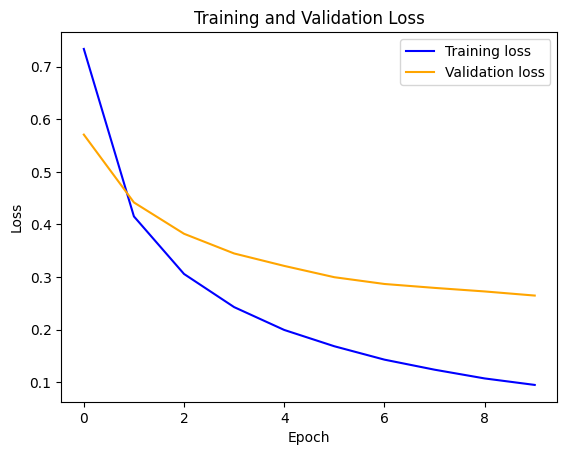

In [184]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.plot(training_loss, label='Training loss', color='blue')
plt.plot(validation_loss, label='Validation loss', color='orange')
plt.legend(loc='upper right')
plt.show()

Compute accuracy, precision, recall and F1-Score:

In [185]:
preds_te = [np.argmax(forward_pass(x, W_trained, dropout=0.0,hidden=False)['y_pred']) 
            for x,y in zip(X_test, Y_test)]

truth = [np.argmax(y) for y in Y_test]
print('Accuracy:', accuracy_score(truth,preds_te))
print('Precision:', precision_score(truth,preds_te,average='macro'))
print('Recall:', recall_score(truth,preds_te,average='macro'))
print('F1-Score:', f1_score(truth,preds_te,average='macro'))

Accuracy: 0.86
Precision: 0.8610280864534592
Recall: 0.86
F1-Score: 0.8594926944322521


In [186]:
error_single = error_analysis(X_test, Y_test, W_trained, id_vocab, hidden = False)

In [188]:
error_single.sort_values(by=['error'],ascending=False).head(10)

,text,true_label,predicted_label,predict_value,prob for truth,error
83,"[unit, airline, cut, routes, london, first, step, plan, 10, routes]",3,1,[0.50776875],[0.4808392],[-0.026929557]
101,"[ap, -, report, consumer, set, off, wall, street, monday, investors, worried, economy, would, third-quarter, earnings, another, drop, oil, prices, failed, market]",3,1,[0.50612414],[0.4729885],[-0.033135653]
55,"[-, just, missed, perfect, week, when, suffered, only, setback, sunday, august, loss, portland]",2,1,[0.5120184],[0.47612035],[-0.03589803]
115,"[new, york,, september, 3, (new, ratings), -, european, union, reportedly, made, significant, progress, settling, antitrust, case, against, co]",3,1,[0.42544803],[0.3705217],[-0.054926336]
58,"[boss, steve, believes, mark, jimmy, one, most, strike, barclays]",2,1,[0.48733068],[0.43208694],[-0.05524373]
124,"[may, back, children, adults]",3,1,[0.49324998],[0.43664354],[-0.05660644]
123,"[survey, most, job, cuts, 6, new, jobs, new, york, -, increased, both, plans, according, survey, released, tuesday, firm]",3,1,[0.5110096],[0.45337164],[-0.05763793]
79,"[andrew, london, (reuters), -, oil, prices, eased, session, monday, iraq, exports, both, southern, after, fighting, holy, city]",3,1,[0.533061],[0.4663344],[-0.066726625]
94,"[canada, united, states, failed, reach, agreement, us, canadian, live, local, press, reported, sunday]",3,1,[0.48428318],[0.40543547],[-0.07884771]
52,"[afp, -, defeated, united, states, olympic, men's, basketball, preliminary, round, game,, only, fourth, loss, 115, olympic, starts, defending, champions]",2,1,[0.53463405],[0.4543144],[-0.08031964]


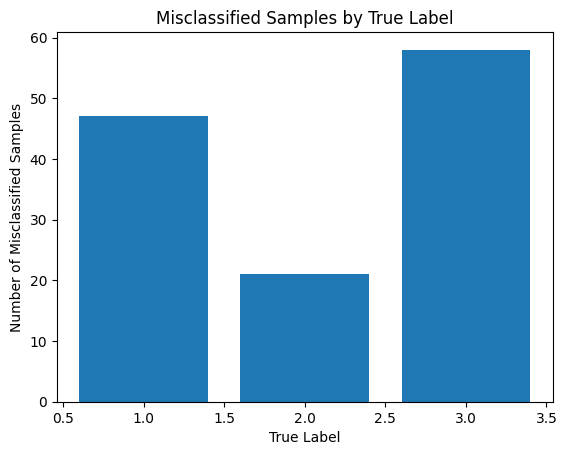

In [189]:
num_misclassified_s = error_single.groupby('true_label').size().reset_index(name='counts')
true_labels = num_misclassified_s['true_label']
counts = num_misclassified_s['counts']

fig, ax = plt.subplots()
ax.bar(true_labels, counts)
ax.set_xlabel('True Label')
ax.set_ylabel('Number of Misclassified Samples')
ax.set_title('Misclassified Samples by True Label')
plt.show()

This model is slightly biased against label 3

### Discuss how did you choose model hyperparameters ? 

# Change Hidden to False for first Two Models

In [243]:
from itertools import product

def Tune_SGD(X_tr, Y_tr, X_val, Y_val,W_list = [], lr_list=[0.001], dropout_list=[0.2], 
             epochs_list=[5], tolerance_list=[0.001], freeze_emb_list=[True], 
             hidden=True, print_progress=True):
    
    # Initialize results dictionary
    results = {}
    stats = pd.DataFrame(columns= ['W','lr','dropout','epochs','tolerance',
                                   'accuracy','precision','recall','F1_score','train_loss','val_loss'])
    
    best_f1_score = 0
    best_params = None
    # Create grid of hyperparameters
    param_grid = {'W': W_list,
                  'lr': lr_list,
                  'dropout': dropout_list,
                  'epochs': epochs_list,
                  'tolerance': tolerance_list,
                  'freeze_emb': freeze_emb_list,
                  }
    
    # Compute all combinations of hyperparameters
    param_combinations = product(*param_grid.values())
    
    # Loop over all combinations of hyperparameters
    for params in param_combinations:
        # Train model with current hyperparameters
        W_tuned, train_loss, val_loss = SGD(X_tr, Y_tr, X_dev=X_val, hidden=hidden,Y_dev=Y_val, **dict(zip(param_grid.keys(), params)))
        
        # Compute validation accuracy
        y_pred = [np.argmax(forward_pass(x, W_tuned, dropout=0.0,hidden=hidden)['y_pred']) for x in X_val]
        truth = [np.argmax(y) for y in Y_val]
        accuracy = accuracy_score(truth, y_pred)
        precision =precision_score(truth,y_pred,average='macro')
        recall = recall_score(truth,y_pred,average='macro')
        F1 = f1_score(truth,y_pred,average='macro')
        
        if F1 > best_f1_score:
            best_f1_score = F1
            best_params = params
        
        # Save results
        results = {'W':params[0],'lr':params[1],'dropout':params[2],'epochs':params[3],'tolerance':params[4],'accuracy': accuracy,'precision': precision,'recall':recall,'F-1':F1, 'train_loss_history':train_loss, 'val_loss_history': val_loss}
        #stats = stats.append(results, ignore_index=True)
        if print_progress:
            stats.loc[len(stats)] = [W_tuned['emb'].shape[1], params[1], params[2], params[3], params[4], accuracy, precision, recall, F1, train_loss[-1], val_loss[-1]]
        
    return results,stats,best_params,best_f1_score

## Different embedding sizes, learning_rates, dropout rates and tolerance rates were permuted through to get the parameters with the best F-1 score. The runtime total was over 5 hours.

In [374]:
W = network_weights(vocab_size=len(vocab), embedding_dim=500,hidden_dim=[], num_classes=3, init_val = 0.5,make_embedding=True,hidden=False)
W_1 = network_weights(vocab_size=len(vocab), embedding_dim=1000,hidden_dim=[], num_classes=3, init_val = 0.5,make_embedding=True,hidden=False)
W_2 = network_weights(vocab_size=len(vocab), embedding_dim=80,hidden_dim=[], num_classes=3, init_val = 0.5,make_embedding=True,hidden=False)
W_3 = network_weights(vocab_size=len(vocab), embedding_dim=300,hidden_dim=[], num_classes=3, init_val = 0.5,make_embedding=True,hidden=False)
Ws = [W,W_1,W_2,W_3]

In [375]:
tuning_results,data,best_para,best_score = Tune_SGD(X_tr, Y_tr, X_dev, Y_dev, Ws,lr_list=[0.01,0.04,0.001], dropout_list=[0.2,0.3],hidden_list=[False],epochs_list=[3,5,10], tolerance_list=[0.001,0.0001], freeze_emb_list=[False], print_progress=True)


Validation loss converged, stopping early
Validation loss converged, stopping early
Validation loss converged, stopping early
Validation loss converged, stopping early
Validation loss converged, stopping early
Validation loss converged, stopping early
Validation loss converged, stopping early
Validation loss converged, stopping early
Validation loss converged, stopping early
Validation loss converged, stopping early
Validation loss converged, stopping early
Validation loss converged, stopping early
Validation loss converged, stopping early
Validation loss converged, stopping early
Validation loss converged, stopping early
Validation loss converged, stopping early
Validation loss converged, stopping early
Validation loss converged, stopping early
Validation loss converged, stopping early
Validation loss converged, stopping early
Validation loss converged, stopping early
Validation loss converged, stopping early
Validation loss converged, stopping early
Validation loss converged, stoppin

In [461]:
data.sort_values(by=['F1_score'],ascending=False).head(3)

,W,lr,dropout,epochs,tolerance,accuracy,precision,recall,F1_score,train_loss,val_loss
0,500.0,0.01,0.2,3.0,0.0010,0.906667,0.907509,0.906667,0.906912,0.314483,0.372123
1,500.0,0.01,0.2,3.0,0.0001,0.906667,0.907509,0.906667,0.906912,0.171428,0.300087
92,80.0,0.04,0.3,5.0,0.0010,0.906667,0.907509,0.906667,0.906912,0.001428,0.301180


In [488]:
print('best_embedding Size',best_para[0]['emb'].shape,'best learning rate :',best_para[1],'best dropout',best_para[2],'epochs',best_para[3],'tolerance:',best_para[4])

best_embedding Size (5000, 500) best learning rate : 0.01 best dropout 0.2 epochs 3 tolerance: 0.001


# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary. Generally, that should work without any problem. If you get errors, you can modify it.

In [190]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb

In [102]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",vocab_id,emb_size=300)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [202]:
W_g = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[], num_classes=3, init_val = 0.5,make_embedding=False,hidden=False)

In [192]:
w_glove.shape

(5000, 300)

In [203]:
W_g['emb']= w_glove

In [204]:
W_trained_glove, training_loss_glove, validation_loss_glove = SGD(X_tr, Y_tr, W_g, X_dev, Y_dev, 
                                                lr=0.0400, dropout=0.3, epochs=10, tolerance=0.00010, 
                                                freeze_emb=True, print_progress=True,n=1,hidden=False)

Epoch 1: Training loss = 0.5901205815109036, Validation loss = 0.42669039910038314
Epoch 2: Training loss = 0.40998028930368796, Validation loss = 0.36559918291556337
Epoch 3: Training loss = 0.3705895072010268, Validation loss = 0.32387469581949213
Epoch 4: Training loss = 0.35175071216785, Validation loss = 0.31301876866879563
Epoch 5: Training loss = 0.340699780694631, Validation loss = 0.27554463454910244
Epoch 6: Training loss = 0.32839115430023713, Validation loss = 0.25574778794660236
Validation loss converged, stopping early


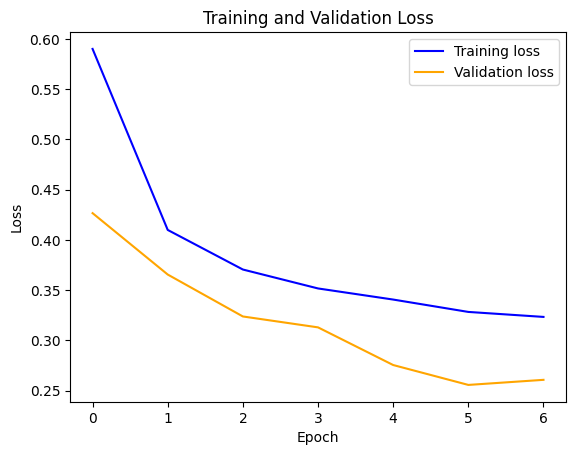

In [205]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.plot(training_loss_glove, label='Training loss', color='blue')
plt.plot(validation_loss_glove, label='Validation loss', color='orange')
plt.legend(loc='upper right')
plt.show()

In [206]:
preds_te_g = [np.argmax(forward_pass(x, W_trained_glove, dropout=0.0,hidden=False)['y_pred']) 
            for x,y in zip(X_test, Y_test)]

truth_g = [np.argmax(y) for y in Y_test]
print('Accuracy:', accuracy_score(truth_g,preds_te_g))
print('Precision:', precision_score(truth_g,preds_te_g,average='macro'))
print('Recall:', recall_score(truth_g,preds_te_g,average='macro'))
print('F1-Score:', f1_score(truth_g,preds_te_g,average='macro'))

Accuracy: 0.8777777777777778
Precision: 0.8771658624599801
Recall: 0.8777777777777778
F1-Score: 0.8772313563761621


In [208]:
error_glove = error_analysis(X_test, Y_test, W_trained_glove, id_vocab, hidden=False)

In [212]:
error_glove.sort_values(by=['error'],ascending=False).head(10)

,text,true_label,predicted_label,predict_value,prob for truth,error
99,"[red, thursday, named, charles, jr, executive, vice, president, chief, financial, officer, kevin, announced, resignation, few, days, before]",3,1,[0.424484],[0.42376837],[-0.00071564317]
78,"[caracas,, venezuela, -, results, support, official, vote, showing, president, hugo, chavez, won, month, #39;s, recall, referendum, head, organization, american, states, said, saturday]",3,1,[0.47059852],[0.4589269],[-0.0116716325]
98,"[lawyers, won, judgment, against, company, fighting, again, maker, monday, asked, illinois, supreme, court, chicago]",3,2,[0.46428552],[0.44543552],[-0.018849999]
64,"[perfect, took, charge, down, stretch, win, running, million, pacific, classic, yesterday]",2,3,[0.4961632],[0.45737183],[-0.03879136]
72,"[ap, -, prospective, jurors, kobe, bryant, rape, case, asked, justice, rich, famous, released, monday]",2,1,[0.4778254],[0.42794383],[-0.049881577]
1,"[supporters, rivals, possible, government, says, defeat, produce, turmoil, world, oil, market]",1,3,[0.5264638],[0.47139508],[-0.05506873]
96,"[deputy, prime, minister, minister, lee, said, monday, nation, #39;s, current, economic, due, #39;, #39;, about, turn, confidence, market, players]",3,1,[0.5153952],[0.4534129],[-0.061982334]
106,"[reuters, -, willis, freelance, writer, mutual, reuters, any]",3,1,[0.4864748],[0.418969],[-0.06750581]
47,"[london, -, retired, pilot, become, oldest, person, swim, english, channel, george, left, england,, saturday, morning, heading, french, coast]",1,2,[0.48178387],[0.40778735],[-0.073996514]
77,"[republican, governor, bush, prescription, drug, policy, federal, court, yesterday,, first, time, state, chosen, legal, battle, over, canadian]",3,1,[0.5323604],[0.45543197],[-0.07692841]


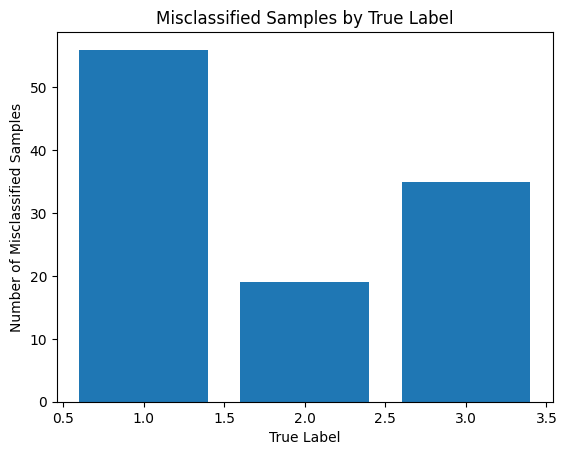

In [213]:
num_misclassified_g = error_glove.groupby('true_label').size().reset_index(name='counts')
true_labels = num_misclassified_g['true_label']
counts = num_misclassified_g['counts']

fig, ax = plt.subplots()
ax.bar(true_labels, counts)
ax.set_xlabel('True Label')
ax.set_ylabel('Number of Misclassified Samples')
ax.set_title('Misclassified Samples by True Label')
plt.show()

This model is biased against label 1

### Discuss how did you choose model hyperparameters ? 

Different parameters were tried like learning rate, dropout rate, tolerance and number of epochs to run.

In [458]:
W_3_g = network_weights(vocab_size=len(vocab), embedding_dim=300,hidden_dim=[], num_classes=3, init_val = 0.5,make_embedding=False,hidden=False)
Ws_g = [W_3_g]

In [459]:
W_3_g['emb']= w_glove

In [460]:
tuning_results_glove,data_glove,best_para_glove,best_score_glove = Tune_SGD(X_tr, Y_tr, X_dev, Y_dev, Ws_g,lr_list=[0.001,0.04,0.0001], dropout_list=[0.2,0.3],hidden_list=[False],epochs_list=[3,5], tolerance_list=[0.0001,0.00001], freeze_emb_list=[True], print_progress=True)


Validation loss converged, stopping early
Validation loss converged, stopping early
Validation loss converged, stopping early
Validation loss converged, stopping early
Validation loss converged, stopping early
Validation loss converged, stopping early
Validation loss converged, stopping early
Validation loss converged, stopping early


In [500]:
data_glove.sort_values(by=['F1_score'],ascending=False).head(3)

,W,lr,dropout,epochs,tolerance,accuracy,precision,recall,F1_score,train_loss,val_loss
14,300.0,0.0400,0.3,5.0,0.00010,0.946667,0.950926,0.946667,0.946914,0.257696,0.208871
23,300.0,0.0001,0.3,5.0,0.00001,0.933333,0.936299,0.933333,0.933698,0.240199,0.202236
19,300.0,0.0001,0.2,5.0,0.00001,0.933333,0.936299,0.933333,0.933698,0.240478,0.201159


# Extend to support deeper architectures 

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. Do deeper architectures increase performance?

In [173]:
W_h = network_weights(vocab_size=len(vocab), embedding_dim=300,hidden_dim=[100], num_classes=3, init_val = 0.5,make_embedding=False,hidden=True)

In [174]:
W_h['emb']= w_glove

In [175]:
W_trained_h, training_loss_h, validation_loss_h = SGD(X_tr, Y_tr, W_h, X_dev, Y_dev,lr=0.0001, dropout=0.2, epochs=30, tolerance=0.001, freeze_emb=True, print_progress=True,n=1,hidden=True)

Epoch 1: Training loss = 2.2011775641215876, Validation loss = 0.6722889442097706
Epoch 2: Training loss = 1.0253798489846535, Validation loss = 0.487965774450325
Epoch 3: Training loss = 0.8307694637058494, Validation loss = 0.4156439686236386
Epoch 4: Training loss = 0.8106827821818351, Validation loss = 0.3768908266459124
Validation loss converged, stopping early


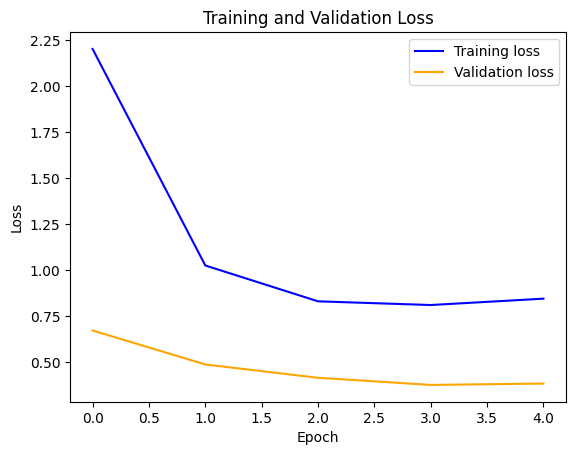

In [176]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.plot(training_loss_h, label='Training loss', color='blue')
plt.plot(validation_loss_h, label='Validation loss', color='orange')
plt.legend(loc='upper right')
plt.show()

In [177]:
preds_h= [np.argmax(forward_pass(x, W_trained_h, dropout=0.0,hidden=True)['y_pred']) 
            for x,y in zip(X_test, Y_test)]

truth_h = [np.argmax(y) for y in Y_test]
print('Accuracy:', accuracy_score(truth_h,preds_h))
print('Precision:', precision_score(truth_h,preds_h,average='macro'))
print('Recall:', recall_score(truth_h,preds_h,average='macro'))
print('F1-Score:', f1_score(truth_h,preds_h,average='macro'))

Accuracy: 0.8122222222222222
Precision: 0.8130135393478076
Recall: 0.8122222222222222
F1-Score: 0.8120516449060963


In [249]:
error_hidden = error_analysis(X_test, Y_test, W_trained_h, id_vocab, hidden=True)
pd.set_option('display.max_colwidth', -1)
error_hidden.sort_values(by=['error'],ascending=False).head(10)

C:\Users\jagpr\AppData\Local\Temp\ipykernel_16532\560645782.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,text,true_label,predicted_label,predict_value,prob for truth,error
127,"[protests, seven, safety, groups, prompted, general, motors, pull, television, ad, shows, young, boy, sports, car, goes, officials, say]",3,2,[0.45298117],[0.42588574],[-0.027095437]
103,"[\$5, million, bank, championship, ryder, cup, few, weeks, away,, first, order, business, yesterday, make, sure, wife, children, headed, safety]",2,3,[0.34363565],[0.3156167],[-0.028018951]
44,"[afp, -, group, calling, itself, secret, islamic, army, release, seven, holding, more, than, month, soon, company, says, iraq,, announced]",1,3,[0.5159499],[0.47962943],[-0.036320478]
89,"[how, like, capital, --, --, sees, tennis, court, rather, than, out, plate, mind, sporting, one, hunger, tennis]",2,3,[0.50326747],[0.4620748],[-0.04119268]
35,"[afp, -, china, warned, singapore, officials, against, visiting, taiwan, again, after, trip, new, leader, just, weeks, before, took, office, strained, ties, beijing]",1,3,[0.5096699],[0.4173631],[-0.09230679]
80,"[afp, -, defeated, united, states, olympic, men's, basketball, preliminary, round, game,, only, fourth, loss, 115, olympic, starts, defending, champions]",2,3,[0.53651404],[0.43841234],[-0.098101705]
57,"[russia, (reuters), -, new, leader, monday, shattered, region, after, winning, election, condemned, rights, groups, show, washington, seriously]",1,2,[0.52840567],[0.42901644],[-0.099389225]
82,"[#39;, became, fastest, woman, qualify, women, #39;s, 100, meters, second, round, olympic, games, here, friday]",2,1,[0.55691874],[0.4418145],[-0.11510423]
104,"[lynch, had, good, win, returned, action, yesterday, along, champion, fellow, williams, after, shock]",2,1,[0.55464077],[0.4332314],[-0.12140936]
39,"[reuters, -, iraqi, seven, employees, company, said, statement, thursday, would, release, once, operations, iraq,, al, television, reported]",1,3,[0.57119405],[0.4284557],[-0.14273834]


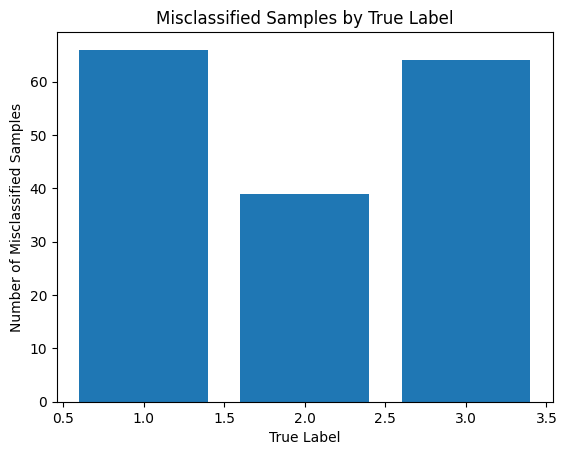

In [250]:
num_misclassified_h = error_hidden.groupby('true_label').size().reset_index(name='counts')
true_labels = num_misclassified_h['true_label']
counts = num_misclassified_h['counts']

fig, ax = plt.subplots()
ax.bar(true_labels, counts)
ax.set_xlabel('True Label')
ax.set_ylabel('Number of Misclassified Samples')
ax.set_title('Misclassified Samples by True Label')
plt.show()

The model seems to be overconfident when it makes errors, as the error is high, This may be due to the following reasons :
1. The size of vocabulary is restricetd to 5000, so it may have induced some bias towards certain labels, despite it being a balanced dataset. This model shows a bias for Label 3.
2. As the data is not very large, with an embedding size of 300, and size of hidden layer and their number may lead to overfitting on the training data.


### Discuss how did you choose model hyperparameters ? 

In [244]:
W_h = network_weights(vocab_size=len(vocab), embedding_dim=300,hidden_dim=[60], num_classes=3, init_val = 0.5,make_embedding=False,hidden=True)
W_1_h = network_weights(vocab_size=len(vocab), embedding_dim=300,hidden_dim=[500], num_classes=3, init_val = 0.5,make_embedding=False,hidden=True)
W_2_h = network_weights(vocab_size=len(vocab), embedding_dim=300,hidden_dim=[20], num_classes=3, init_val = 0.5,make_embedding=False,hidden=True)
W_3_h = network_weights(vocab_size=len(vocab), embedding_dim=300,hidden_dim=[30], num_classes=3, init_val = 0.5,make_embedding=False,hidden=True)
Ws_h = [W_h,W_1_h,W_2_h,W_3_h]

In [245]:
W_h['emb']= w_glove
W_1_h['emb']= w_glove
W_2_h['emb']= w_glove
W_3_h['emb']= w_glove

In [246]:
tuning_results_deep,data_deep,best_para_deep,best_score_deep = Tune_SGD(X_tr, Y_tr, X_dev, Y_dev, Ws_h,lr_list=[0.01], dropout_list=[0.2],epochs_list=[3,5], tolerance_list=[0.0001], freeze_emb_list=[True], print_progress=True,hidden=True)


C:\Users\jagpr\AppData\Local\Temp\ipykernel_16532\3056430362.py:7: RuntimeWarning: invalid value encountered in subtract
  x -= np.max(x).astype('float32')
d:\work\work\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\work\work\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss converged, stopping early


d:\work\work\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [248]:
pd.set_option('display.width', 1000)
data_deep.sort_values(by=['F1_score'],ascending=False).head(3)

,W,lr,dropout,epochs,tolerance,accuracy,precision,recall,F1_score,train_loss,val_loss
1,300.0,0.01,0.2,5.0,0.0001,0.820000,0.844284,0.820000,0.811111,4.315069,3.042697
5,300.0,0.01,0.2,5.0,0.0001,0.733333,0.756928,0.733333,0.735928,6.056265,2.958952
6,300.0,0.01,0.2,3.0,0.0001,0.606667,0.661724,0.606667,0.579708,5.554595,3.225623


## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  | 90.07  |90.66   | 90.69  | 90.66  |
| Average Embedding (Pre-trained)  |95.09   |94.66   | 94.69  | 94.66  |
| Average Embedding (Pre-trained) + X hidden layers    | 84.4  | 82.00  | 81.11  |  82.00 |


Please discuss why your best performing model is better than the rest and provide a bried error analaysis.

The Best Performing model is : Model number 2 with Pre-trained Embeddings.

The problem with model 3 seems to be exploding gradients which cause log(0) to produce nan  which hinder learning over  longer epochs and bigger size hidden layers. Otherwise, the expectation would be that Model 3 would have performed best but it seems due to the small vocab size chosen and embedding size of 300, more layers are not required and it seems to overfit beyond 100 neurons anda single layer.

The First Model is more or less at par with the Pre-trained Glove Embedding Model, However it takes time to train and is slower than GloVE model when training.

GLove Model Performed best as its embeddings are trained on a much larger dataset, so they capture the relativity among the words which co-occur together more precisely.


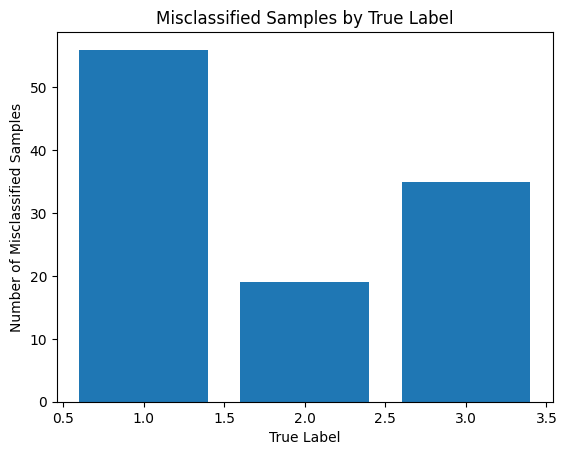

In [251]:
num_misclassified_g = error_glove.groupby('true_label').size().reset_index(name='counts')
true_labels = num_misclassified_g['true_label']
counts = num_misclassified_g['counts']

fig, ax = plt.subplots()
ax.bar(true_labels, counts)
ax.set_xlabel('True Label')
ax.set_ylabel('Number of Misclassified Samples')
ax.set_title('Misclassified Samples by True Label')
plt.show()

# Error Analysis: 

In [287]:
error_glove.sort_values(by=['error'])

,text,true_label,predicted_label,predict_value,prob for truth,error
28,"[shares, indian, software, services, giant, close, 16, higher, market, raising, company]",1,3,[0.99957687],[0.0003465431],[-0.9992303]
52,"[pitched, chicago, cubs, into, lead, nl, wild-card, race, gave, win, remember, threw, seven, innings, career, got, victory, manager, chicago, beat, montreal, expos, 5-2, monday, night]",1,2,[0.99903715],[0.0008423027],[-0.9981949]
25,"[athens,, greece, -, americans, got, taste, like, good, days, finally, played, opponent, able, beat, monday, final, preliminary, game, olympic, men's, basketball, tournament]",1,2,[0.9972103],[0.002176927],[-0.9950334]
37,"[united, states, beat, brazil, extra, time, win, women's, olympic, football, tournament]",1,2,[0.99682164],[0.0024896287],[-0.994332]
33,"[athens,, greece, -, expected,, us, men's, basketball, team, had, hands, full, game, against, thursday]",1,2,[0.9951096],[0.002939871],[-0.99216974]
...,...,...,...,...,...,...
72,"[ap, -, prospective, jurors, kobe, bryant, rape, case, asked, justice, rich, famous, released, monday]",2,1,[0.4778254],[0.42794383],[-0.049881577]
64,"[perfect, took, charge, down, stretch, win, running, million, pacific, classic, yesterday]",2,3,[0.4961632],[0.45737183],[-0.03879136]
98,"[lawyers, won, judgment, against, company, fighting, again, maker, monday, asked, illinois, supreme, court, chicago]",3,2,[0.46428552],[0.44543552],[-0.018849999]
78,"[caracas,, venezuela, -, results, support, official, vote, showing, president, hugo, chavez, won, month, #39;s, recall, referendum, head, organization, american, states, said, saturday]",3,1,[0.47059852],[0.4589269],[-0.0116716325]


1) The model Seems overconfident when making errors as it measure very little probabilty for true label.
2)  The choice of vocabulary is causing all three models to favor label 2 in predicting accurately, It may be due to the co-occurence and therefore, only words per label count may not be the best metric for choosing vocab size.
